In [75]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb

# from tqdm import tqdm # 如果在普通python脚本环境
from tqdm.notebook import tqdm  # 如果在notebook环境，使用这个导入
import gc
import warnings
from datetime import timedelta
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    auc,
)  # 确保导入 auc
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)  # 忽略一些未来的警告

# ------- CACHE ---------
BASE_DIR = "/Users/pp/projects/51MCM2025/program"
X_train_online_path = os.path.join(BASE_DIR, "train_data/X_train_online.csv")
X_val_online_path = os.path.join(BASE_DIR, "train_data/X_val_online.csv")
Y_train_online_path = os.path.join(BASE_DIR, "train_data/y_train_online.csv")
Y_val_online_path = os.path.join(BASE_DIR, "train_data/Y_val_online.csv")
interaction_features_path = os.path.join(
    BASE_DIR, "train_data/interaction_features.csv"
)
interaction_labels_path = os.path.join(BASE_DIR, "train_data/interaction_labels.csv")
interaction_model_path = os.path.join(BASE_DIR, "train_data/interaction_model.joblib")
feature_cols_interaction_path = os.path.join(
    BASE_DIR, "train_data/feature_cols_interaction.csv"
)
interaction_train_df_path = os.path.join(
    BASE_DIR, "train_data/interaction_train_df.csv"
)
interaction_lgb_params_path=os.path.join(BASE_DIR, "train_data/interaction_lgb_params.joblib")
# --------------------

# --- 1. 数据加载与预处理 ---
print("Loading data...")
dtype_spec = {
    "UserID": "category",
    "UserBehaviour": "int8",
    "BloggerID": "category",
    "Time": "str",
}

# Problem 3只需要附件1的数据
# 注意：如果数据文件不在当前脚本同级目录的'program'文件夹下，请修改路径
try:
    df_hist = pd.read_csv(
        "/Users/pp/projects/51MCM2025/program/a1.csv", dtype=dtype_spec
    )
except FileNotFoundError:
    print("Error: 'program/a1.csv' not found. Please check the file path.")
    exit()

Loading data...


In [76]:
print("Preprocessing data...")
df_hist["Time"] = pd.to_datetime(df_hist["Time"])
df_hist["Date"] = pd.to_datetime(df_hist["Time"].dt.date)

# --- 时间点定义 ---
hist_start_date = pd.to_datetime("2024-07-11")
hist_end_date = pd.to_datetime("2024-07-20")  # 历史数据截止日期
predict_date = pd.to_datetime("2024-07-21")  # 预测目标日期

print(f"History data range: {hist_start_date.date()} to {hist_end_date.date()}")
print(f"Prediction date: {predict_date.date()}")

# Problem 3 目标用户列表
target_users_p3 = ["U9", "U22405", "U16", "U48420"]

print("Data loaded and preprocessed.")
gc.collect()

Preprocessing data...
History data range: 2024-07-11 to 2024-07-20
Prediction date: 2024-07-21
Data loaded and preprocessed.


27714

In [77]:
# %% [markdown]
# ### 辅助函数：构建历史特征 (适配 Problem 3) - 包含时序特征
# (此函数内部的填充逻辑主要处理子窗口内的NaN，最终合并后的NaN在外部处理)

# %%
import pandas as pd
import numpy as np
import gc


def create_historical_features(df_hist_subset, reference_date):
    """
    为给定的历史数据子集创建历史特征，包括不同时间窗口的时序特征。
    不包含“当天互动特征”。

    Args:
        df_hist_subset (pd.DataFrame): 历史行为数据，包含 UserID, BloggerID, UserBehaviour, Date, Time。
        reference_date (pd.Timestamp): 特征计算的截止日期 (包含)。预测日期的前一天。

    Returns:
        tuple: (user_agg, blogger_agg, user_blogger_hist_agg)
               包含用户、博主、用户-博主对的聚合特征，已合并时序特征。
    """
    # print(f"Creating historical features based on data up to {reference_date.date()}...") # 移除这个打印

    # 确保 Date 列是 datetime 类型
    df_hist_subset["Date"] = pd.to_datetime(df_hist_subset["Date"])

    # 筛选出截止日期之前的数据
    # 使用 .copy() 避免 SettingWithCopyWarning
    hist_ref = df_hist_subset[df_hist_subset["Date"] <= reference_date].copy()

    # 如果 hist_ref 为空，直接返回空DataFrame
    if hist_ref.empty:
        print(
            f"Warning: No historical data found up to {reference_date.date()}. Returning empty dataframes."
        )
        # 返回带有必要列名的空DataFrame，以便后续merge不会报错
        # 提前定义所有可能的列名会更健壮，但这里先简化处理，确保关键ID列存在
        # 外部合并时需要处理这些空DataFrame带来的NaN
        user_agg = pd.DataFrame(columns=["UserID"])
        blogger_agg = pd.DataFrame(columns=["BloggerID"])
        user_blogger_hist_agg = pd.DataFrame(columns=["UserID", "BloggerID"])
        # 可以在这里手动添加一些关键列，并指定dtype，例如
        # user_agg = pd.DataFrame(columns=['UserID', 'user_hist_interactions', 'user_days_since_last_active', ...])
        # user_agg = user_agg.astype({'UserID': 'category', 'user_hist_interactions': 'float64', ...})
        # 但考虑到外部填充逻辑，只要ID列存在，大部分数值列的NaN会在外部被正确处理
        return user_agg, blogger_agg, user_blogger_hist_agg

    # --- 计算全局/用户/博主级别的聚合特征 (整个历史期间 up to reference_date) ---
    # print("Calculating global/user/blogger features...") # 移除这个打印
    user_agg = (
        hist_ref.groupby("UserID")
        .agg(
            user_hist_interactions=(
                "BloggerID",
                "count",
            ),  # Total interactions (all behaviours) in full history
            user_hist_unique_bloggers=("BloggerID", "nunique"),
            user_hist_follows=("UserBehaviour", lambda x: (x == 4).sum()),
            user_hist_views=("UserBehaviour", lambda x: (x == 1).sum()),
            user_hist_likes=("UserBehaviour", lambda x: (x == 2).sum()),
            user_hist_comments=("UserBehaviour", lambda x: (x == 3).sum()),
            user_active_days=("Date", "nunique"),  # Active days in full history
            user_first_active_date=("Date", "min"),
            user_last_active_date=("Date", "max"),
        )
        .reset_index()
    )
    user_agg["user_follow_rate"] = user_agg["user_hist_follows"] / user_agg[
        "user_hist_interactions"
    ].replace(0, 1)
    user_agg["user_days_since_last_active"] = (
        reference_date - user_agg["user_last_active_date"]
    ).dt.days
    user_agg["user_account_age_days"] = (
        reference_date - user_agg["user_first_active_date"]
    ).dt.days

    blogger_agg = (
        hist_ref.groupby("BloggerID")
        .agg(
            blogger_hist_interactions=(
                "UserID",
                "count",
            ),  # Total interactions received in full history
            blogger_hist_unique_users=("UserID", "nunique"),
            blogger_hist_follows=(
                "UserBehaviour",
                lambda x: (x == 4).sum(),
            ),  # Follows received
            blogger_hist_views=(
                "UserBehaviour",
                lambda x: (x == 1).sum(),
            ),  # Views received
            blogger_hist_likes=(
                "UserBehaviour",
                lambda x: (x == 2).sum(),
            ),  # Likes received
            blogger_hist_comments=(
                "UserBehaviour",
                lambda x: (x == 3).sum(),
            ),  # Comments received
            blogger_active_days=(
                "Date",
                "nunique",
            ),  # Active days (had interactions) in full history
            blogger_first_active_date=("Date", "min"),
            blogger_last_active_date=("Date", "max"),
        )
        .reset_index()
    )
    blogger_agg["blogger_follow_rate"] = blogger_agg[
        "blogger_hist_follows"
    ] / blogger_agg["blogger_hist_interactions"].replace(0, 1)
    blogger_agg["blogger_days_since_last_active"] = (
        reference_date - blogger_agg["blogger_last_active_date"]
    ).dt.days
    blogger_agg["blogger_account_age_days"] = (
        reference_date - blogger_agg["blogger_first_active_date"]
    ).dt.days

    gc.collect()

    # --- 计算用户-博主交互特征 (整个历史期间 up to reference_date) ---
    # print("Calculating user-blogger interaction features...") # 移除这个打印
    user_blogger_hist_agg = (
        hist_ref.groupby(["UserID", "BloggerID"])
        .agg(
            ub_hist_interactions=(
                "Time",
                "count",
            ),  # Total interactions in full history
            ub_hist_views=("UserBehaviour", lambda x: (x == 1).sum()),
            ub_hist_likes=("UserBehaviour", lambda x: (x == 2).sum()),
            ub_hist_comments=("UserBehaviour", lambda x: (x == 3).sum()),
            ub_hist_follows=(
                "UserBehaviour",
                lambda x: (x == 4).sum(),
            ),  # Add ub follows
            ub_first_interaction_date=("Date", "min"),
            ub_last_interaction_date=("Date", "max"),
            ub_interaction_days=("Date", "nunique"),  # Interaction days in full history
        )
        .reset_index()
    )
    user_blogger_hist_agg["ub_days_since_first_interaction"] = (
        reference_date - user_blogger_hist_agg["ub_first_interaction_date"]
    ).dt.days
    user_blogger_hist_agg["ub_days_since_last_interaction"] = (
        reference_date - user_blogger_hist_agg["ub_last_interaction_date"]
    ).dt.days
    user_blogger_hist_agg["ub_interaction_frequency"] = user_blogger_hist_agg[
        "ub_hist_interactions"
    ] / user_blogger_hist_agg["ub_interaction_days"].replace(0, 1)
    user_blogger_hist_agg["ub_follow_rate"] = user_blogger_hist_agg[
        "ub_hist_follows"
    ] / user_blogger_hist_agg["ub_hist_interactions"].replace(
        0, 1
    )  # Add ub follow rate

    gc.collect()

    # --- 构建时序特征 ---
    # print("Building time-windowed features...") # 移除这个打印
    time_windows = [
        1,
        3,
        7,
    ]  # Define time windows (in days). 10 days is covered by full history.

    # User Time-Series Features
    # Iterate over a copy of UserID to avoid issues if user_agg is modified
    for window in time_windows:
        window_start_date = reference_date - pd.Timedelta(days=window - 1)
        # Filter data for the current window (within the already filtered hist_ref)
        df_window = hist_ref[hist_ref["Date"] >= window_start_date].copy()

        # Get list of users present in this window
        users_in_window = df_window["UserID"].unique()

        if not df_window.empty:
            # Total interactions (Like, Comment, Follow) in window
            interaction_behaviors_window = df_window[
                df_window["UserBehaviour"].isin([2, 3, 4])
            ].copy()
            user_interactions_window = (
                interaction_behaviors_window.groupby("UserID")
                .size()
                .reset_index(name=f"user_total_interactions_last_{window}d")
            )
            user_agg = pd.merge(
                user_agg, user_interactions_window, on="UserID", how="left"
            )

            # Behaviour counts in window
            for behaviour_type, behaviour_name in zip(
                [1, 2, 3, 4], ["view", "like", "comment", "follow"]
            ):
                user_behaviour_count = (
                    df_window[df_window["UserBehaviour"] == behaviour_type]
                    .groupby("UserID")
                    .size()
                    .reset_index(name=f"user_{behaviour_name}_count_last_{window}d")
                )
                user_agg = pd.merge(
                    user_agg, user_behaviour_count, on="UserID", how="left"
                )

            # Active days in window
            user_active_days_window = (
                df_window.groupby("UserID")["Date"]
                .nunique()
                .reset_index(name=f"user_active_days_last_{window}d")
            )
            user_agg = pd.merge(
                user_agg, user_active_days_window, on="UserID", how="left"
            )

            # Days since last active in window
            user_last_active_date_window = (
                df_window.groupby("UserID")["Date"]
                .max()
                .reset_index(name=f"user_last_active_date_last_{window}d")
            )
            user_agg = pd.merge(
                user_agg, user_last_active_date_window, on="UserID", how="left"
            )
            user_agg[f"user_days_since_last_active_last_{window}d"] = (
                reference_date - user_agg[f"user_last_active_date_last_{window}d"]
            ).dt.days
            user_agg = user_agg.drop(f"user_last_active_date_last_{window}d", axis=1)

            # Average daily interactions in window (handle division by zero/NaN)
            # Need the total interactions and active days columns for this window first
            # Ensure the columns exist before calculating frequency and fill NaNs for users NOT in window
            total_interactions_col = f"user_total_interactions_last_{window}d"
            active_days_col = f"user_active_days_last_{window}d"
            days_since_col = f"user_days_since_last_active_last_{window}d"

            # Fill NaNs for users who were in user_agg (full history) but NOT in df_window (this window)
            # Count/sum features should be 0
            user_agg[total_interactions_col] = user_agg[total_interactions_col].fillna(
                0
            )
            for behaviour_name in ["view", "like", "comment", "follow"]:
                col_name = f"user_{behaviour_name}_count_last_{window}d"
                user_agg[col_name] = user_agg[col_name].fillna(0)
            user_agg[active_days_col] = user_agg[active_days_col].fillna(0)
            # Days since last active should be at least window days ago if no activity in window
            user_agg[days_since_col] = user_agg[days_since_col].fillna(window)

            # Calculate frequency AFTER filling counts and active days
            user_agg[f"user_avg_daily_interactions_last_{window}d"] = user_agg[
                total_interactions_col
            ] / user_agg[active_days_col].replace(
                0, np.nan
            )  # Use np.nan to avoid ZeroDivisionError
            user_agg[f"user_avg_daily_interactions_last_{window}d"] = user_agg[
                f"user_avg_daily_interactions_last_{window}d"
            ].fillna(
                0
            )  # Fill NaN (where active_days was 0) with 0

        else:
            # If window is empty (e.g., reference_date is too early), add columns filled with 0 or a default large number for days since last active
            # Ensure these columns are added even if df_window is empty
            user_agg[f"user_total_interactions_last_{window}d"] = 0
            for behaviour_name in ["view", "like", "comment", "follow"]:
                user_agg[f"user_{behaviour_name}_count_last_{window}d"] = 0
            user_agg[f"user_active_days_last_{window}d"] = 0
            # If no activity in this window, days since last active is at least window days ago
            user_agg[f"user_days_since_last_active_last_{window}d"] = window
            user_agg[f"user_avg_daily_interactions_last_{window}d"] = 0

        gc.collect()

    # User-Blogger Time-Series Features
    # Iterate over a copy of UserID, BloggerID to avoid issues if user_blogger_hist_agg is modified
    for window in time_windows:
        window_start_date = reference_date - pd.Timedelta(days=window - 1)
        # Filter data for the current window (within the already filtered hist_ref)
        df_window = hist_ref[hist_ref["Date"] >= window_start_date].copy()

        # Get list of ub pairs present in this window
        ub_in_window = df_window[["UserID", "BloggerID"]].drop_duplicates()

        if not df_window.empty:
            # Total interactions (all behaviours) in window
            ub_interactions_window = (
                df_window.groupby(["UserID", "BloggerID"])
                .size()
                .reset_index(name=f"ub_total_interactions_last_{window}d")
            )
            user_blogger_hist_agg = pd.merge(
                user_blogger_hist_agg,
                ub_interactions_window,
                on=["UserID", "BloggerID"],
                how="left",
            )

            # Behaviour counts in window
            for behaviour_type, behaviour_name in zip(
                [1, 2, 3, 4], ["view", "like", "comment", "follow"]
            ):
                ub_behaviour_count = (
                    df_window[df_window["UserBehaviour"] == behaviour_type]
                    .groupby(["UserID", "BloggerID"])
                    .size()
                    .reset_index(name=f"ub_{behaviour_name}_count_last_{window}d")
                )
                user_blogger_hist_agg = pd.merge(
                    user_blogger_hist_agg,
                    ub_behaviour_count,
                    on=["UserID", "BloggerID"],
                    how="left",
                )

            # Days since last interaction in window
            ub_last_interaction_date_window = (
                df_window.groupby(["UserID", "BloggerID"])["Date"]
                .max()
                .reset_index(name=f"ub_last_interaction_date_last_{window}d")
            )
            user_blogger_hist_agg = pd.merge(
                user_blogger_hist_agg,
                ub_last_interaction_date_window,
                on=["UserID", "BloggerID"],
                how="left",
            )
            user_blogger_hist_agg[f"ub_days_since_last_interaction_last_{window}d"] = (
                reference_date
                - user_blogger_hist_agg[f"ub_last_interaction_date_last_{window}d"]
            ).dt.days
            user_blogger_hist_agg = user_blogger_hist_agg.drop(
                f"ub_last_interaction_date_last_{window}d", axis=1
            )

            # Fill NaNs for ub pairs who were in user_blogger_hist_agg (full history) but NOT in df_window (this window)
            # Count features should be 0
            total_interactions_col = f"ub_total_interactions_last_{window}d"
            user_blogger_hist_agg[total_interactions_col] = user_blogger_hist_agg[
                total_interactions_col
            ].fillna(0)
            for behaviour_name in ["view", "like", "comment", "follow"]:
                col_name = f"ub_{behaviour_name}_count_last_{window}d"
                user_blogger_hist_agg[col_name] = user_blogger_hist_agg[
                    col_name
                ].fillna(0)
            # Days since last interaction should be at least window days ago if no activity in window
            days_since_col = f"ub_days_since_last_interaction_last_{window}d"
            user_blogger_hist_agg[days_since_col] = user_blogger_hist_agg[
                days_since_col
            ].fillna(window)

        else:
            # If window is empty, add columns filled with 0 or a default large number for days since last active
            # Ensure these columns are added even if df_window is empty
            user_blogger_hist_agg[f"ub_total_interactions_last_{window}d"] = 0
            for behaviour_name in ["view", "like", "comment", "follow"]:
                user_blogger_hist_agg[f"ub_{behaviour_name}_count_last_{window}d"] = 0
            # If no activity in this window, days since last interaction is at least window days ago
            user_blogger_hist_agg[f"ub_days_since_last_interaction_last_{window}d"] = (
                window
            )

        gc.collect()

    # --- 填充在 **create_historical_features 内部**产生的 NaN ---
    # 这些 NaN 是因为 left merge 导致某个用户/对在某个特定**子窗口**内没有行为，
    # 但他们在整个 hist_ref 期间是存在的。
    # 对于计数特征，填充为 0 是正确的。
    # 对于 days_since_last_active/interaction (time-windowed), 填充为窗口大小是合理的近似值。
    # Note: The filling for time-windowed features is now done *inside* the time window loops.
    # This section can be removed or kept for clarity that full-history features are NOT filled here.

    # # 填充用户时序特征的 NaN (仅限 time_windows 定义的窗口) - REMOVED, handled inside loops
    # user_time_cols_internal = [col for col in user_agg.columns if col.startswith('user_') and '_last_' in col]
    # for col in user_time_cols_internal:
    #     if 'days_since_last_active_last_' in col: # More specific check
    #         window_str = col.split('_last_')[-1].replace('d', '')
    #         window_size = int(window_str)
    #         user_agg[col] = user_agg[col].fillna(window_size)
    #     else:
    #         user_agg[col] = user_agg[col].fillna(0)

    # # 填充用户-博主对时序特征的 NaN (仅限 time_windows 定义的窗口) - REMOVED, handled inside loops
    # ub_time_cols_internal = [col for col in user_blogger_hist_agg.columns if col.startswith('ub_') and '_last_' in col]
    # for col in ub_time_cols_internal:
    #     if 'days_since_last_interaction_last_' in col: # More specific check
    #         window_str = col.split('_last_')[-1].replace('d', '')
    #         window_size = int(window_str)
    #         user_blogger_hist_agg[col] = user_blogger_hist_agg[col].fillna(window_size)
    #     else:
    #          user_blogger_hist_agg[col] = user_blogger_hist_agg[col].fillna(0)

    # 删除不再需要的原始日期列 (已经在计算 days_since 时使用了)
    date_cols_to_drop = [
        "user_first_active_date",
        "user_last_active_date",
        "blogger_first_active_date",
        "blogger_last_active_date",
        "ub_first_interaction_date",
        "ub_last_interaction_date",
    ]
    user_agg = user_agg.drop(
        columns=[col for col in date_cols_to_drop if col in user_agg.columns],
        errors="ignore",
    )
    blogger_agg = blogger_agg.drop(
        columns=[col for col in date_cols_to_drop if col in blogger_agg.columns],
        errors="ignore",
    )
    user_blogger_hist_agg = user_blogger_hist_agg.drop(
        columns=[
            col for col in date_cols_to_drop if col in user_blogger_hist_agg.columns
        ],
        errors="ignore",
    )

    gc.collect()

    return user_agg, blogger_agg, user_blogger_hist_agg

In [78]:
# --- 2. 子任务 1: 预测用户 2024.7.21 是否在线 ---
import os

print("\n--- Building Training and Validation Data for Online Prediction ---")
# 训练集：预测 7.20 是否在线，特征基于 7.11-7.19
if not (
    os.path.exists(X_train_online_path)
    and os.path.exists(Y_train_online_path)
    and os.path.exists(X_val_online_path)
    and os.path.exists(Y_val_online_path)
):
    print(
        "Processing data for online prediction training (Predicting 7.20 based on 7.11-7.19)..."
    )
    train_pred_date_online = pd.to_datetime("2024-07-20")
    train_hist_end_online = train_pred_date_online - timedelta(days=1)  # 7.19
    user_features_train_online_base, _, _ = create_historical_features(
        df_hist, train_hist_end_online
    )
    # 找到在 7.20 活跃的用户 (训练标签)
    active_on_train_date_online = df_hist[df_hist["Date"] == train_pred_date_online][
        "UserID"
    ].unique()
    # 获取所有在历史数据中出现过的用户 + 7.20 活跃的用户，确保标签集包含所有可能的用户
    all_users_for_train_label = np.union1d(
        user_features_train_online_base["UserID"].unique(), active_on_train_date_online
    )
    user_features_train_online = pd.DataFrame({"UserID": all_users_for_train_label})
    user_features_train_online = pd.merge(
        user_features_train_online,
        user_features_train_online_base,
        on="UserID",
        how="left",
    )  # Left merge to keep all users in label set
    user_features_train_online["is_online"] = (
        user_features_train_online["UserID"]
        .isin(active_on_train_date_online)
        .astype(int)
    )

    # 验证集：预测 7.19 是否在线，特征基于 7.11-7.18
    print(
        "Processing data for online prediction validation (Predicting 7.19 based on 7.11-7.18)..."
    )
    val_pred_date_online = pd.to_datetime("2024-07-19")
    val_hist_end_online = val_pred_date_online - timedelta(days=1)  # 7.18
    user_features_val_online_base, _, _ = create_historical_features(
        df_hist, val_hist_end_online
    )
    # 找到在 7.19 活跃的用户 (验证标签)
    active_on_val_date_online = df_hist[df_hist["Date"] == val_pred_date_online][
        "UserID"
    ].unique()
    # 获取所有在历史数据中出现过的用户 + 7.19 活跃的用户，确保标签集包含所有可能的用户
    all_users_for_val_label = np.union1d(
        user_features_val_online_base["UserID"].unique(), active_on_val_date_online
    )
    user_features_val_online = pd.DataFrame({"UserID": all_users_for_val_label})
    user_features_val_online = pd.merge(
        user_features_val_online, user_features_val_online_base, on="UserID", how="left"
    )  # Left merge to keep all users in label set
    user_features_val_online["is_online"] = (
        user_features_val_online["UserID"].isin(active_on_val_date_online).astype(int)
    )
    gc.collect()

    # --- 修正点：区分不同类型的特征进行填充 ---
    # 在线预测数据的填充 (训练集和验证集)
    print(
        "Filling missing values for online training and validation data (distinguishing feature types)..."
    )

    # 定义一个较大的值，用于填充 days_since 类特征的 NaN
    # 历史窗口是 10 天 (7.11-7.20)，最长的 days_since_last_active_hist 是 9。
    # 如果完全没有历史活动，距离参考日期的天数应该是一个较大的值。
    # 参考日期对于训练集是 7.19，对于验证集是 7.18。
    # 最大历史天数是 10天 (7.11-7.20)。如果用户在 7.11 之前活跃，距离 7.19 至少 8天，距离 7.18 至少 7天。
    # 如果用户在整个 7.11-7.19 (训练) 或 7.11-7.18 (验证) 都没有活动，
    # 他们最后活跃日期肯定在 7.11 之前。距离 7.19 至少 9天，距离 7.18 至少 8天。
    # 使用一个比最大窗口天数 (10) 稍大的值，例如 11，作为标记值。
    large_days_value = 11

    # 填充训练数据
    print("Filling NaNs for online training data...")
    # 找到所有 days_since_last_active 相关的列名
    user_days_since_cols_train = [
        col
        for col in user_features_train_online.columns
        if "days_since_last_active" in col
    ]
    # 对 days_since 列使用较大的值填充
    for col in user_days_since_cols_train:
        user_features_train_online[col] = user_features_train_online[col].fillna(
            large_days_value
        )
    # 对其他数值列使用 0 填充
    numeric_cols_train = user_features_train_online.select_dtypes(
        include=np.number
    ).columns
    other_numeric_cols_train = numeric_cols_train.difference(
        user_days_since_cols_train
    ).difference(["is_online"])
    user_features_train_online[other_numeric_cols_train] = user_features_train_online[
        other_numeric_cols_train
    ].fillna(0)

    # 填充验证数据
    print("Filling NaNs for online validation data...")
    # 找到所有 days_since_last_active 相关的列名
    user_days_since_cols_val = [
        col
        for col in user_features_val_online.columns
        if "days_since_last_active" in col
    ]
    # 对 days_since 列使用较大的值填充
    for col in user_days_since_cols_val:
        user_features_val_online[col] = user_features_val_online[col].fillna(
            large_days_value
        )
    # 对其他数值列使用 0 填充
    numeric_cols_val = user_features_val_online.select_dtypes(include=np.number).columns
    other_numeric_cols_val = numeric_cols_val.difference(
        user_days_since_cols_val
    ).difference(["is_online"])
    user_features_val_online[other_numeric_cols_val] = user_features_val_online[
        other_numeric_cols_val
    ].fillna(0)

    # 准备训练和验证数据
    # 确保训练集和验证集特征列一致
    X_train_online = user_features_train_online.drop(columns=["UserID", "is_online"])
    y_train_online = user_features_train_online["is_online"]
    X_val_online = user_features_val_online.drop(columns=["UserID", "is_online"])
    y_val_online = user_features_val_online["is_online"]

    # 确保验证集特征列与训练集一致 (处理可能因为历史数据不同导致列不一致的情况)
    # 简单方法是只保留训练集中存在的特征列
    X_val_online = X_val_online[X_train_online.columns]

    # 如果 X_train_online 是 DataFrame，y_train_online 是 Series
    X_train_online.to_csv(X_train_online_path, index=False)
    X_val_online.to_csv(X_val_online_path, index=False)
    y_train_online.to_csv(Y_train_online_path, index=False)
    y_val_online.to_csv(Y_val_online_path, index=False)

    print(
        f"Online prediction training data shape: {X_train_online.shape}, labels shape: {y_train_online.shape}"
    )
    print(
        f"Online prediction validation data shape: {X_val_online.shape}, labels shape: {y_val_online.shape}"
    )
    gc.collect()
else:
    X_val_online = pd.read_csv(X_val_online_path)
    y_train_online = pd.read_csv(Y_train_online_path)
    y_val_online = pd.read_csv(Y_val_online_path)
    X_train_online = pd.read_csv(X_train_online_path)
    print(
        f"Online prediction training data shape: {X_train_online.shape}, labels shape: {y_train_online.shape}"
    )
    print(
        f"Online prediction validation data shape: {X_val_online.shape}, labels shape: {y_val_online.shape}"
    )


--- Building Training and Validation Data for Online Prediction ---
Online prediction training data shape: (19998, 34), labels shape: (19998, 1)
Online prediction validation data shape: (19998, 34), labels shape: (19998, 1)


In [79]:
print("\n--- Training LightGBM Classifier for Online Prediction ---")
# 定义模型参数
online_lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "n_estimators": 1000,
    "n_jobs": -1,
    "seed": 42,
    "is_unbalance": True,  # 如果正负样本不平衡可以尝试开启
}
online_model = lgb.LGBMClassifier(**online_lgb_params)
print("Starting online model fitting...")
# 在训练集上训练模型
online_model.fit(X_train_online, y_train_online)
print("Online model training finished.")


--- Training LightGBM Classifier for Online Prediction ---
Starting online model fitting...
Online model training finished.



--- Evaluating Online Model on Validation Set and Selecting Threshold ---
Calculating metrics for different thresholds...


Evaluating Thresholds:   0%|          | 0/99 [00:00<?, ?it/s]


Best threshold for F1-score on validation set: 0.2000
F1-score at this threshold: 0.7514
Precision at this threshold: 0.6053
Recall at this threshold: 0.9904

Best threshold for Recall >= 0.8 and max Precision: 0.4300
Precision: 0.6485, Recall: 0.8046

Plot saved as Precision_Recall_F1-Score_vs_Threshold_on_Validation_Set.pdf

Plot saved as online_prediction_pr_curve.pdf


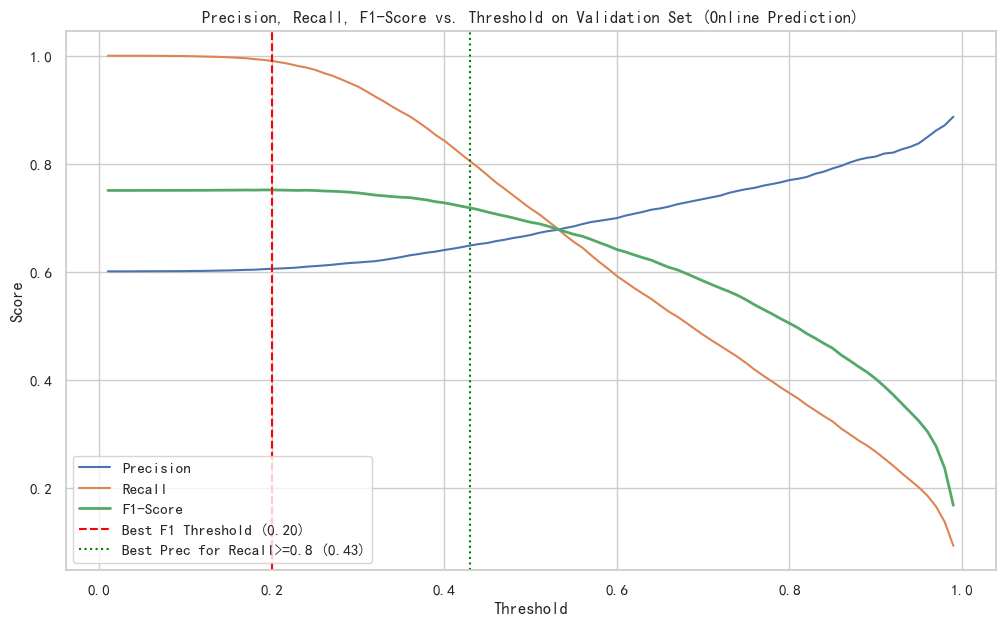

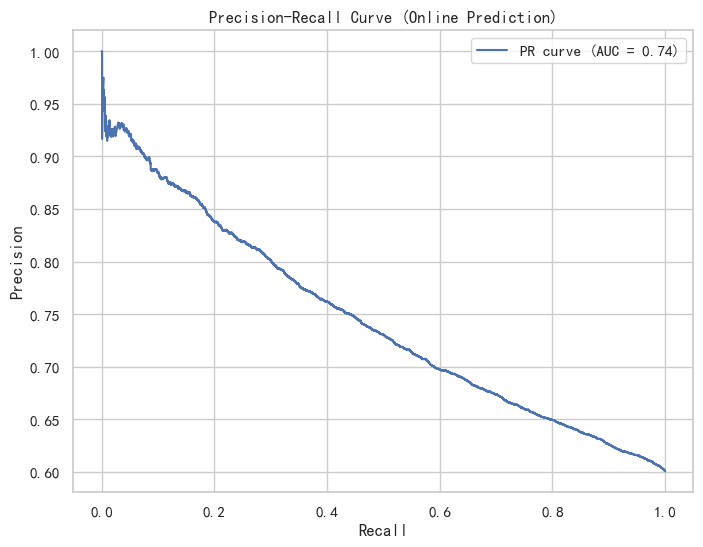

In [80]:
# --- 在验证集上评估并选择最佳阈值 ---
print("\n--- Evaluating Online Model on Validation Set and Selecting Threshold ---")
# 在验证集上预测概率
y_pred_proba_val_online = online_model.predict_proba(X_val_online)[:, 1]
# 计算 Precision, Recall, F1-Score 随阈值变化
thresholds = np.arange(0.01, 1.0, 0.01)  # 候选阈值范围 (从0.01开始避免除零)
precisions = []
recalls = []
f1_scores = []
print("Calculating metrics for different thresholds...")
for thresh in tqdm(thresholds, desc="Evaluating Thresholds"):
    # 将概率按当前阈值转换为 0/1 预测
    y_pred_binary_val = (y_pred_proba_val_online >= thresh).astype(int)
    # 计算指标 (注意 zero_division=0 避免除以零警告)
    precisions.append(precision_score(y_val_online, y_pred_binary_val, zero_division=0))
    recalls.append(recall_score(y_val_online, y_pred_binary_val, zero_division=0))
    f1_scores.append(f1_score(y_val_online, y_pred_binary_val, zero_division=0))
# 找到最佳阈值 (例如，使 F1 分数最高的阈值)
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_idx]
print(f"\nBest threshold for F1-score on validation set: {best_threshold_f1:.4f}")
print(f"F1-score at this threshold: {f1_scores[best_f1_idx]:.4f}")
print(f"Precision at this threshold: {precisions[best_f1_idx]:.4f}")
print(f"Recall at this threshold: {recalls[best_f1_idx]:.4f}")

min_recall_target = 0.8  # 示例：至少要找到 80%
valid_threshold_indices = [i for i, r in enumerate(recalls) if r >= min_recall_target]
if valid_threshold_indices:
    best_precision_idx = valid_threshold_indices[
        np.argmax(np.array(precisions)[valid_threshold_indices])
    ]
    best_threshold_prec_recall = thresholds[best_precision_idx]
    print(
        f"\nBest threshold for Recall >= {min_recall_target} and max Precision: {best_threshold_prec_recall:.4f}"
    )
    print(
        f"Precision: {precisions[best_precision_idx]:.4f}, Recall: {recalls[best_precision_idx]:.4f}"
    )
else:
    print(
        f"\nCould not find a threshold meeting the minimum Recall requirement of {min_recall_target}"
    )

# 可视化指标随阈值变化
plt.figure(figsize=(12, 7))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1-Score", linewidth=2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title(
    "Precision, Recall, F1-Score vs. Threshold on Validation Set (Online Prediction)"
)
plt.axvline(
    best_threshold_f1,
    color="red",
    linestyle="--",
    label=f"Best F1 Threshold ({best_threshold_f1:.2f})",
)
# 如果用了第二种方法，也可以画出那条线
if valid_threshold_indices:
    plt.axvline(
        best_threshold_prec_recall,
        color="green",
        linestyle=":",
        label=f"Best Prec for Recall>={min_recall_target} ({best_threshold_prec_recall:.2f})",
    )
plt.legend()
plt.legend()
plt.grid(True)

pdf_filename_online_metrics = (
    "Precision_Recall_F1-Score_vs_Threshold_on_Validation_Set.pdf"
)
plt.savefig(
    pdf_filename_online_metrics, format="pdf", bbox_inches="tight"
)  # format='pdf' 指定格式, bbox_inches='tight' 尝试去除多余边距
print(f"\nPlot saved as {pdf_filename_online_metrics}")

# 绘制 PR 曲线 (可选)
precision_pr, recall_pr, _ = precision_recall_curve(
    y_val_online, y_pred_proba_val_online
)
auc_pr = auc(recall_pr, precision_pr)
plt.figure(figsize=(8, 6))
plt.plot(recall_pr, precision_pr, label=f"PR curve (AUC = {auc_pr:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Online Prediction)")
plt.legend()
plt.grid(True)
# 保存图表
pdf_filename_online_pr = "online_prediction_pr_curve.pdf"
plt.savefig(
    pdf_filename_online_pr, format="pdf", bbox_inches="tight"
)  # format='pdf' 指定格式, bbox_inches='tight' 尝试去除多余边距
print(f"\nPlot saved as {pdf_filename_online_pr}")
plt.show()  # 如果你想在保存后仍然显示图形，取消这行的注释
plt.close("all")  # 关闭所有图形，释放内存

In [81]:
# --- 使用选择的最佳阈值进行 7.21 在线预测 ---
final_online_prediction_threshold = precisions[best_precision_idx]
print(
    f"\nUsing final online prediction threshold: {final_online_prediction_threshold:.4f}"
)
print("\n--- Predicting 7.21 Online Status for Target Users ---")
# 为目标用户计算基于 7.11-7.20 的特征
predict_online_users_df = pd.DataFrame({"UserID": target_users_p3})
print("Calculating historical features for target users (up to 7.20)...")
# 使用 create_historical_features 函数
predict_online_features_calc, _, _ = create_historical_features(
    df_hist, hist_end_date
)  # 7.20
# 合并目标用户列表与计算出的特征 (使用 left merge 保留所有目标用户)
predict_online_features = pd.merge(
    predict_online_users_df, predict_online_features_calc, on="UserID", how="left"
)

# --- 修正点：区分不同类型的特征进行填充 (预测数据) ---
print(
    "Filling missing values for target user prediction features (distinguishing feature types)..."
)
# 找到所有 days_since_last_active 相关的列名
user_days_since_cols_pred = [
    col for col in predict_online_features.columns if "days_since_last_active" in col
]
# 对 days_since 列使用较大的值填充
for col in user_days_since_cols_pred:
    predict_online_features[col] = predict_online_features[col].fillna(
        large_days_value
    )  # 使用之前定义的 large_days_value
# 对其他数值列使用 0 填充
numeric_cols_pred = predict_online_features.select_dtypes(include=np.number).columns
other_numeric_cols_pred = numeric_cols_pred.difference(user_days_since_cols_pred)
predict_online_features[other_numeric_cols_pred] = predict_online_features[
    other_numeric_cols_pred
].fillna(0)


# 确保预测特征列与训练特征列一致且顺序相同
# 只保留训练集中存在的特征列
predict_online_features = predict_online_features[X_train_online.columns]


Using final online prediction threshold: 0.6485

--- Predicting 7.21 Online Status for Target Users ---
Calculating historical features for target users (up to 7.20)...
Filling missing values for target user prediction features (distinguishing feature types)...


In [82]:
# 预测在线概率
online_pred_proba = online_model.predict_proba(predict_online_features)[:, 1]
predict_online_users_df["online_proba"] = online_pred_proba
# 根据选择的阈值判断是否在线
predicted_online_users = predict_online_users_df[
    predict_online_users_df["online_proba"] >= final_online_prediction_threshold
]["UserID"].tolist()
print(f"Predicted {len(predicted_online_users)} target users to be online on 7.21.")
print(f"Predicted online users: {predicted_online_users}")
gc.collect()

Predicted 3 target users to be online on 7.21.
Predicted online users: ['U9', 'U22405', 'U48420']


4


Plot saved as Online_Probability_for_Selected_Users_7_21.pdf


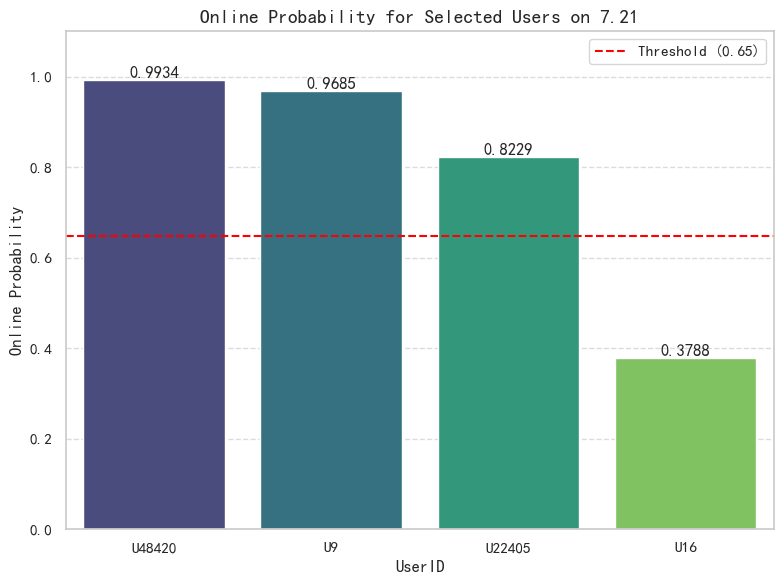

,UserID,online_proba
0,U9,0.968492
1,U22405,0.822864
2,U16,0.378816
3,U48420,0.993390


In [83]:
# 数据
data = {
    "UserID": target_users_p3,  # 使用原始目标用户列表
    "online_proba": online_pred_proba,
}
df_online_proba_viz = pd.DataFrame(data)

# 为了让图表更清晰，按概率降序排序
df_sorted_proba = df_online_proba_viz.sort_values(by="online_proba", ascending=False)

# 创建图表和轴对象
plt.figure(figsize=(8, 6))
# 使用 seaborn 的 barplot
ax = sns.barplot(
    x="UserID", y="online_proba", data=df_sorted_proba, palette="viridis"
)  # palette 可以设置颜色主题

# 添加标题和轴标签 (使用 Matplotlib)
plt.title("Online Probability for Selected Users on 7.21", fontsize=14)
plt.xlabel("UserID", fontsize=12)
plt.ylabel("Online Probability", fontsize=12)
plt.ylim(0, 1.1)  # 设置Y轴范围
plt.axhline(
    final_online_prediction_threshold,
    color="red",
    linestyle="--",
    label=f"Threshold ({final_online_prediction_threshold:.2f})",
)
plt.legend()

# 在每个柱子上方显示具体的概率值 (使用 Matplotlib 和轴对象)
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",  # 格式化概率值，保留4位小数
        (p.get_x() + p.get_width() / 2.0, p.get_height()),  # 文本位置 (x, y)
        ha="center",
        va="center",  # 水平垂直对齐
        xytext=(0, 5),  # 文本相对于位置的偏移量 (x, y)
        textcoords="offset points",
    )

# 显示网格线 (可选)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 自动调整布局，防止文本重叠
plt.tight_layout()

pdf_filename_online_proba = "Online_Probability_for_Selected_Users_7_21.pdf"
plt.savefig(
    pdf_filename_online_proba, format="pdf", bbox_inches="tight"
)  # format='pdf' 指定格式, bbox_inches='tight' 尝试去除多余边距
print(f"\nPlot saved as {pdf_filename_online_proba}")

# 显示图表
plt.show()

predict_online_users_df

In [84]:
print("\n--- Outputting All User Online Predictions ---")
# 假设 predict_online_users_df 已经包含了 'UserID' 和 'online_proba' 列
# 并且 final_online_prediction_threshold 已经确定

# 确认 DataFrame 存在并包含必要的列
if (
    "predict_online_users_df" in locals()
    and isinstance(predict_online_users_df, pd.DataFrame)
    and "online_proba" in predict_online_users_df.columns
):
    # 根据阈值进行分类预测
    # 大于等于阈值的为 True (预测在线)，小于阈值的为 False (预测不在线)
    predict_online_users_df["predicted_online"] = (
        predict_online_users_df["online_proba"] >= final_online_prediction_threshold
    )

    print(
        f"已根据阈值 {final_online_prediction_threshold} 为所有用户添加了 'predicted_online' 列。"
    )

    # 显示部分预测结果（前5行）
    print("\n部分预测结果 (前5行):")
    print(predict_online_users_df.head())

    # 显示部分预测为在线的用户
    print("\n部分预测为在线的用户 (前5行):")
    print(
        predict_online_users_df[
            predict_online_users_df["predicted_online"] == True
        ].head()
    )

    # 显示部分预测为不在线的用户
    print("\n部分预测为不在线的用户 (前5行):")
    print(
        predict_online_users_df[
            predict_online_users_df["predicted_online"] == False
        ].head()
    )

    # 如果用户数量很多，直接打印不方便，建议保存到文件
    output_filename_online_all = "all_user_online_predictions_7_21.csv"
    predict_online_users_df.to_csv(output_filename_online_all, index=False)
    print(f"\n所有用户的预测结果已保存到文件: {output_filename_online_all}")


else:
    print(
        "错误：找不到 predict_online_users_df DataFrame，或者它不包含 'online_proba' 列。请确保您已经运行了生成预测的代码，并且 DataFrame 名称正确。"
    )


--- Outputting All User Online Predictions ---
已根据阈值 0.6484799677873968 为所有用户添加了 'predicted_online' 列。

部分预测结果 (前5行):
   UserID  online_proba  predicted_online
0      U9      0.968492              True
1  U22405      0.822864              True
2     U16      0.378816             False
3  U48420      0.993390              True

部分预测为在线的用户 (前5行):
   UserID  online_proba  predicted_online
0      U9      0.968492              True
1  U22405      0.822864              True
3  U48420      0.993390              True

部分预测为不在线的用户 (前5行):
  UserID  online_proba  predicted_online
2    U16      0.378816             False

所有用户的预测结果已保存到文件: all_user_online_predictions_7_21.csv


In [85]:
# --- 3. 子任务 2: 预测在线用户的互动博主 (Top 3) ---
print("\n--- Building Training Data for Interaction Prediction ---")
interaction_train_data = []
is_exists_interaction_train_data = (
    os.path.exists(interaction_features_path)
    and os.path.exists(interaction_labels_path)
    and os.path.exists(feature_cols_interaction_path)
    and os.path.exists(interaction_train_df_path)
)
if not (is_exists_interaction_train_data):
    # 训练样本 1: 预测 7.19 的互动总数，特征基于 7.11-7.18
    print(
        "Processing data for interaction prediction training (Predicting 7.19 based on 7.11-7.18)..."
    )
    inter_date_1 = pd.to_datetime("2024-07-19")
    hist_end_1_inter = inter_date_1 - timedelta(days=1)  # 7.18
    # 找到在 7.19 发生互动 (2,3,4) 的 (UserID, BloggerID) 对
    interaction_on_date_1 = df_hist[
        (df_hist["Date"] == inter_date_1) & (df_hist["UserBehaviour"].isin([2, 3, 4]))
    ].copy()
    # 计算每个对的总互动数 (2,3,4) 作为标签
    interaction_labels_1 = (
        interaction_on_date_1.groupby(["UserID", "BloggerID"])
        .size()
        .reset_index(name="total_interaction_count")
    )
    interaction_labels_1["inter_date"] = inter_date_1
    # 计算这些对的特征 (基于 7.11-7.18)
    user_agg_1_inter, blogger_agg_1_inter, ub_agg_1_inter = create_historical_features(
        df_hist, hist_end_1_inter
    )
    # 合并特征和标签
    print("Merging features and labels for 7.19 interaction training...")
    interaction_features_1 = pd.merge(
        interaction_labels_1, user_agg_1_inter, on="UserID", how="left"
    )
    interaction_features_1 = pd.merge(
        interaction_features_1, blogger_agg_1_inter, on="BloggerID", how="left"
    )
    interaction_features_1 = pd.merge(
        interaction_features_1, ub_agg_1_inter, on=["UserID", "BloggerID"], how="left"
    )
    interaction_train_data.append(interaction_features_1)

    gc.collect()


--- Building Training Data for Interaction Prediction ---


In [86]:
# 训练样本 2: 预测 7.20 的互动总数，特征基于 7.11-7.19
print(
    "Processing data for interaction prediction training (Predicting 7.20 based on 7.11-7.19)..."
)
if not (is_exists_interaction_train_data):
    inter_date_2 = pd.to_datetime("2024-07-20")
    hist_end_2_inter = inter_date_2 - timedelta(days=1)  # 7.19
    # 找到在 7.20 发生互动 (2,3,4) 的 (UserID, BloggerID) 对
    interaction_on_date_2 = df_hist[
        (df_hist["Date"] == inter_date_2) & (df_hist["UserBehaviour"].isin([2, 3, 4]))
    ].copy()
    # 计算每个对的总互动数 (2,3,4) 作为标签
    interaction_labels_2 = (
        interaction_on_date_2.groupby(["UserID", "BloggerID"])
        .size()
        .reset_index(name="total_interaction_count")
    )
    interaction_labels_2["inter_date"] = inter_date_2
    # 计算这些对的特征 (基于 7.11-7.19)
    user_agg_2_inter, blogger_agg_2_inter, ub_agg_2_inter = create_historical_features(
        df_hist, hist_end_2_inter
    )
    # 合并特征和标签
    print("Merging features and labels for 7.20 interaction training...")
    interaction_features_2 = pd.merge(
        interaction_labels_2, user_agg_2_inter, on="UserID", how="left"
    )
    interaction_features_2 = pd.merge(
        interaction_features_2, blogger_agg_2_inter, on="BloggerID", how="left"
    )
    interaction_features_2 = pd.merge(
        interaction_features_2, ub_agg_2_inter, on=["UserID", "BloggerID"], how="left"
    )
    interaction_train_data.append(interaction_features_2)
    gc.collect()

Processing data for interaction prediction training (Predicting 7.20 based on 7.11-7.19)...


In [87]:
# 合并训练数据
print("Concatenating interaction training data...")
if not (is_exists_interaction_train_data):
    interaction_train_df = pd.concat(interaction_train_data, ignore_index=True)

    # --- 修正点：区分不同类型的特征进行填充 (互动训练数据) ---
    print(
        "Filling missing values for interaction training data (distinguishing feature types)..."
    )
    # 定义一个较大的值 (同上)
    large_days_value = 11
    # 找到所有 days_since 相关的列名
    # 包括用户、博主、用户-博主对的 days_since 列
    inter_days_since_cols_train = [
        col
        for col in interaction_train_df.columns
        if "days_since_last_active" in col or "days_since_last_interaction" in col
    ]

    # 对 days_since 列使用较大的值填充
    for col in inter_days_since_cols_train:
        interaction_train_df[col] = interaction_train_df[col].fillna(large_days_value)

    # 对其他数值列使用 0 填充
    # 选择需要填充的数值列，排除非数值列 (UserID, BloggerID, total_interaction_count, inter_date) 以及 days_since 列
    numeric_cols_inter_train = interaction_train_df.select_dtypes(
        include=np.number
    ).columns
    other_numeric_cols_inter_train = numeric_cols_inter_train.difference(
        inter_days_since_cols_train
    ).difference(["UserID", "BloggerID", "total_interaction_count", "inter_date"])
    interaction_train_df[other_numeric_cols_inter_train] = interaction_train_df[
        other_numeric_cols_inter_train
    ].fillna(0)

    # 准备训练数据
    interaction_labels = interaction_train_df["total_interaction_count"]
    interaction_features = interaction_train_df.drop(
        columns=["UserID", "BloggerID", "total_interaction_count", "inter_date"]
    )
    # 确保列名一致
    feature_cols_interaction = interaction_features.columns.tolist()

    interaction_features.to_csv(interaction_features_path, index=False)
    interaction_labels.to_csv(interaction_labels_path, index=False)
    pd.Series(feature_cols_interaction).to_csv(feature_cols_interaction_path, index=False, header=False)
    interaction_train_df.to_csv(interaction_train_df_path, index=False)

    print(
        f"Interaction prediction training data shape: {interaction_features.shape}, labels shape: {interaction_labels.shape}"
    )
    gc.collect()

Concatenating interaction training data...


In [88]:
if is_exists_interaction_train_data:
    interaction_features = pd.read_csv(interaction_features_path)
    interaction_labels = pd.read_csv(interaction_labels_path)
    feature_cols_interaction = pd.read_csv(feature_cols_interaction_path, header=None).squeeze("columns").tolist()
    interaction_train_df = pd.read_csv(interaction_train_df_path)

In [89]:
print("\n--- Training LightGBM Regressor for Interaction Prediction ---")
if not (os.path.exists(interaction_lgb_params_path)):
    # 定义模型参数
    interaction_lgb_params = {
        "objective": "regression_l1",  # 预测计数，使用L1损失或L2损失
        "metric": "rmse",
        "boosting_type": "gbdt",
        "num_leaves": 31,
        "learning_rate": 0.05,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "verbose": -1,
        "n_estimators": 1000,
        "n_jobs": -1,
        "seed": 42,
    }
    interaction_model = lgb.LGBMRegressor(**interaction_lgb_params)
    print("Starting interaction model fitting...")
    interaction_model.fit(interaction_features, interaction_labels)
    print("Interaction model training finished.")

    joblib.dump(interaction_model, interaction_lgb_params_path)
else:
    interaction_model = joblib.load(interaction_lgb_params_path)


--- Training LightGBM Regressor for Interaction Prediction ---


In [90]:
print("\n--- Predicting Top 3 Interaction Bloggers for Online Users on 7.21 ---")
problem3_results = {user_id: [] for user_id in target_users_p3}
if predicted_online_users:
    print(f"Processing predicted online users: {predicted_online_users}")
    # 为每个预测为在线的用户，生成候选博主列表
    # 候选博主：该用户在 7.11-7.20 期间互动过的所有博主
    candidate_pairs_list = []
    print("Generating candidate user-blogger pairs for prediction...")
    # 使用 tqdm 包装外部循环
    for user_id in tqdm(predicted_online_users, desc="Generating pairs"):
        user_hist_df = df_hist[df_hist["UserID"] == user_id].copy()
        if not user_hist_df.empty:
            # 考虑所有行为类型作为历史互动过的博主
            interacted_bloggers = user_hist_df["BloggerID"].unique().tolist()
            for blogger_id in interacted_bloggers:
                # 确保 BloggerID 转换为字符串以便后续处理，虽然 category dtype 应该没问题，但显式转换更安全
                candidate_pairs_list.append(
                    {"UserID": user_id, "BloggerID": str(blogger_id)}
                )

    if candidate_pairs_list:
        predict_interaction_df = pd.DataFrame(candidate_pairs_list)
        print(f"Generated {len(predict_interaction_df)} candidate user-blogger pairs.")

        # 计算这些候选对的特征 (基于 7.11-7.20)
        print("Calculating historical features for prediction pairs (up to 7.20)...")
        user_agg_pred, blogger_agg_pred, ub_agg_pred = create_historical_features(
            df_hist, hist_end_date
        )  # 7.20

        print("Merging features for prediction pairs...")
        # 使用 Left merge 从候选对开始，保留所有候选对
        predict_interaction_features = pd.merge(
            predict_interaction_df, user_agg_pred, on="UserID", how="left"
        )
        predict_interaction_features = pd.merge(
            predict_interaction_features, blogger_agg_pred, on="BloggerID", how="left"
        )
        predict_interaction_features = pd.merge(
            predict_interaction_features,
            ub_agg_pred,
            on=["UserID", "BloggerID"],
            how="left",
        )

        # --- 修正点：区分不同类型的特征进行填充 (互动预测数据) ---
        print(
            "Filling missing values for prediction features (distinguishing feature types)..."
        )
        # 定义一个较大的值 (同上)
        large_days_value = 11
        # 找到所有 days_since 相关的列名
        inter_days_since_cols_pred = [
            col
            for col in predict_interaction_features.columns
            if "days_since_last_active" in col or "days_since_last_interaction" in col
        ]

        # 对 days_since 列使用较大的值填充
        for col in inter_days_since_cols_pred:
            predict_interaction_features[col] = predict_interaction_features[
                col
            ].fillna(large_days_value)

        # 对其他数值列使用 0 填充
        # 选择需要填充的数值列，排除非数值列 (UserID, BloggerID) 以及 days_since 列
        numeric_cols_inter_pred = predict_interaction_features.select_dtypes(
            include=np.number
        ).columns
        other_numeric_cols_inter_pred = numeric_cols_inter_pred.difference(
            inter_days_since_cols_pred
        ).difference(["UserID", "BloggerID"])
        predict_interaction_features[other_numeric_cols_inter_pred] = (
            predict_interaction_features[other_numeric_cols_inter_pred].fillna(0)
        )

        # 确保预测特征列与训练特征列一致且顺序相同
        # 只保留训练集中存在的特征列
        # 检查所有 feature_cols_interaction 是否存在于 predict_interaction_features 中
        missing_cols = set(feature_cols_interaction) - set(
            predict_interaction_features.columns
        )
        if missing_cols:
            print(
                f"Warning: Missing columns in prediction features: {missing_cols}. Filling with 0."
            )
            for col in missing_cols:
                predict_interaction_features[col] = 0  # Fill missing columns with 0

        predict_interaction_features = predict_interaction_features[
            feature_cols_interaction
        ]

        print(f"Prediction data shape: {predict_interaction_features.shape}")

        print("Predicting interaction counts for candidate pairs...")
        # 预测互动总数
        predicted_interaction_counts = interaction_model.predict(
            predict_interaction_features
        )
        predict_interaction_df["predicted_interaction_count"] = (
            predicted_interaction_counts
        )
        # 对预测互动数为负数的情况进行处理，将其设为0 (互动数不能为负)
        predict_interaction_df["predicted_interaction_count"] = predict_interaction_df[
            "predicted_interaction_count"
        ].apply(lambda x: max(0, x))

        print("Ranking bloggers and selecting Top 3 for each user...")
        # 按用户分组，选择预测互动数最高的 Top 3 博主
        # 使用 tqdm 包装 groupby 后的迭代
        for user_id, user_predictions in tqdm(
            predict_interaction_df.groupby("UserID"), desc="Selecting Top 3 Bloggers"
        ):
            user_predictions = user_predictions.sort_values(
                by="predicted_interaction_count", ascending=False
            )
            # 选择预测互动数 > 0 的博主，如果不足3个，则选择所有预测 > 0 的博主
            top_bloggers_df = user_predictions[
                user_predictions["predicted_interaction_count"] > 0
            ].head(3)
            top_bloggers = top_bloggers_df["BloggerID"].tolist()
            # 确保博主ID转换为字符串
            problem3_results[user_id] = [str(bid) for bid in top_bloggers]
    else:
        print(
            "No historical interaction pairs found for predicted online users. Cannot generate interaction predictions."
        )
else:
    print(
        "No target users predicted to be online on 7.21. Skipping interaction prediction."
    )
gc.collect()


--- Predicting Top 3 Interaction Bloggers for Online Users on 7.21 ---
Processing predicted online users: ['U9', 'U22405', 'U48420']
Generating candidate user-blogger pairs for prediction...


Generating pairs:   0%|          | 0/3 [00:00<?, ?it/s]

Generated 64 candidate user-blogger pairs.
Calculating historical features for prediction pairs (up to 7.20)...
Merging features for prediction pairs...
Filling missing values for prediction features (distinguishing feature types)...
Prediction data shape: (64, 72)
Predicting interaction counts for candidate pairs...
Ranking bloggers and selecting Top 3 for each user...


Selecting Top 3 Bloggers:   0%|          | 0/3 [00:00<?, ?it/s]

49

In [91]:
# --- 4. 格式化输出结果 (表3) ---
print("\n--- Generating Final Results for Table 3 ---")
# 创建结果DataFrame
table3_data = []
for user_id in target_users_p3:
    # 即使用户没有被预测为在线，或没有互动博主，也需要在表中包含他们，并留空博主列
    bloggers = problem3_results.get(user_id, [])
    row = {"用户ID": user_id}
    for i in range(3):
        row[f"博主ID {i+1}"] = (
            bloggers[i] if i < len(bloggers) else ""
        )  # 如果不足3个则留空
    table3_data.append(row)
table3_df = pd.DataFrame(table3_data)
print("\n--- 问题3 预测结果 ---")
print(table3_df.to_string(index=False))


--- Generating Final Results for Table 3 ---

--- 问题3 预测结果 ---
  用户ID 博主ID 1 博主ID 2 博主ID 3
    U9    B13     B7    B24
U22405    B52    B42    B47
   U16                     
U48420     B5     B2    B21


Starting data distribution visualization...


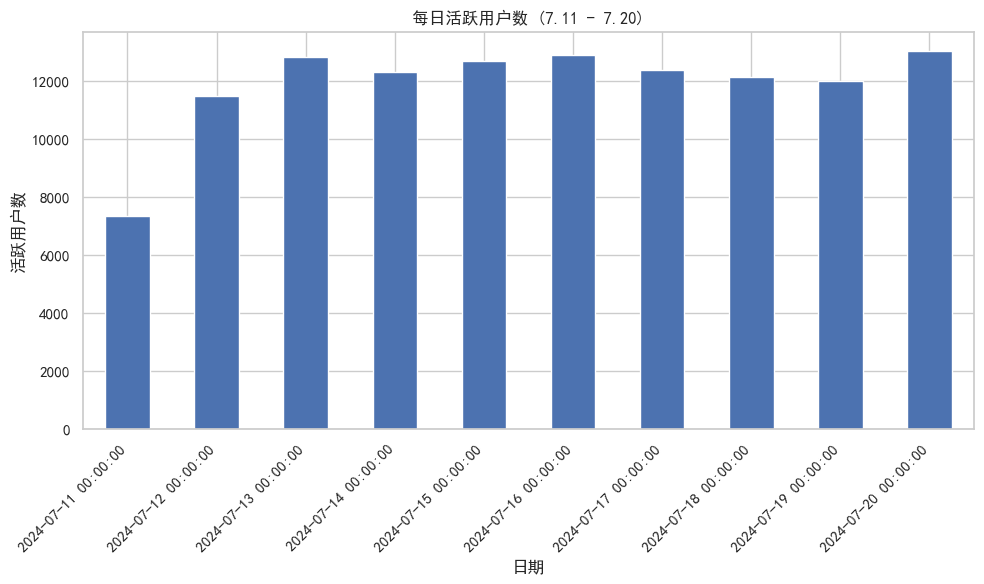

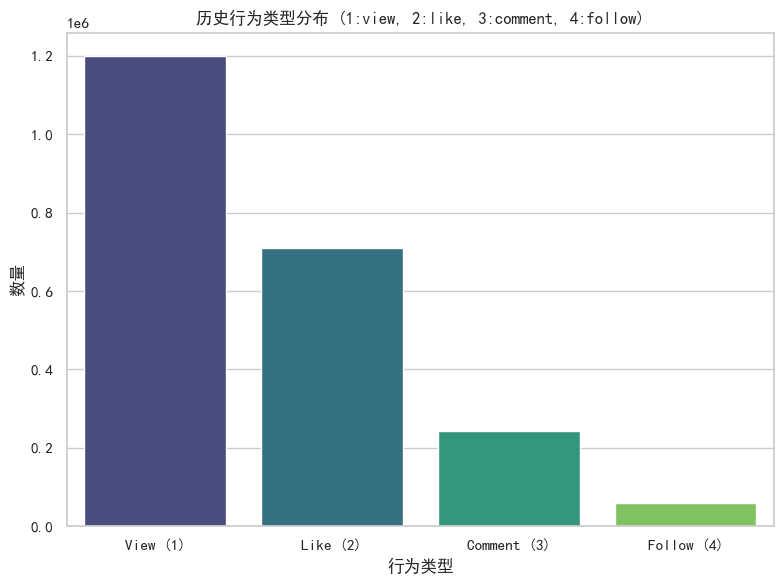

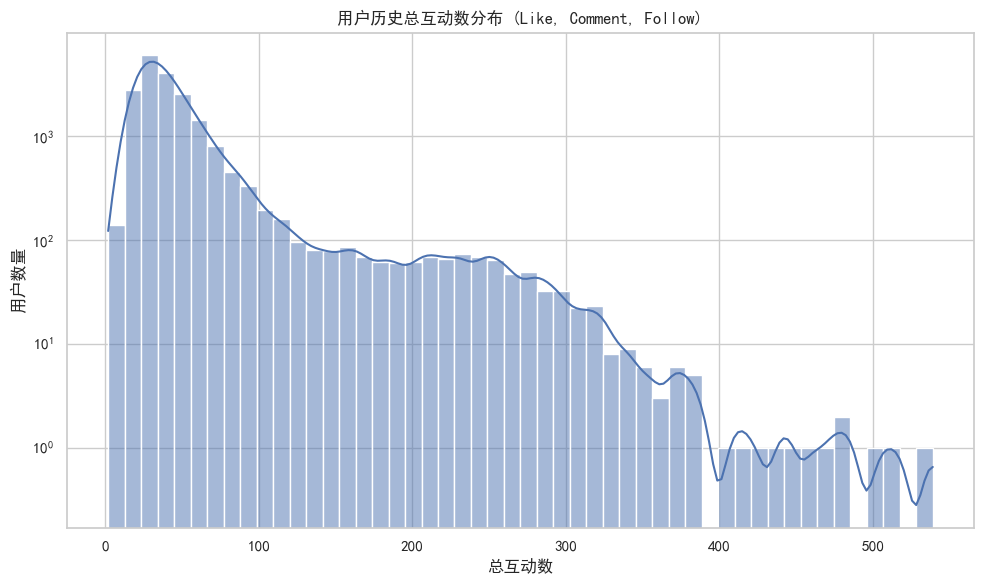


Visualizing features for online prediction...


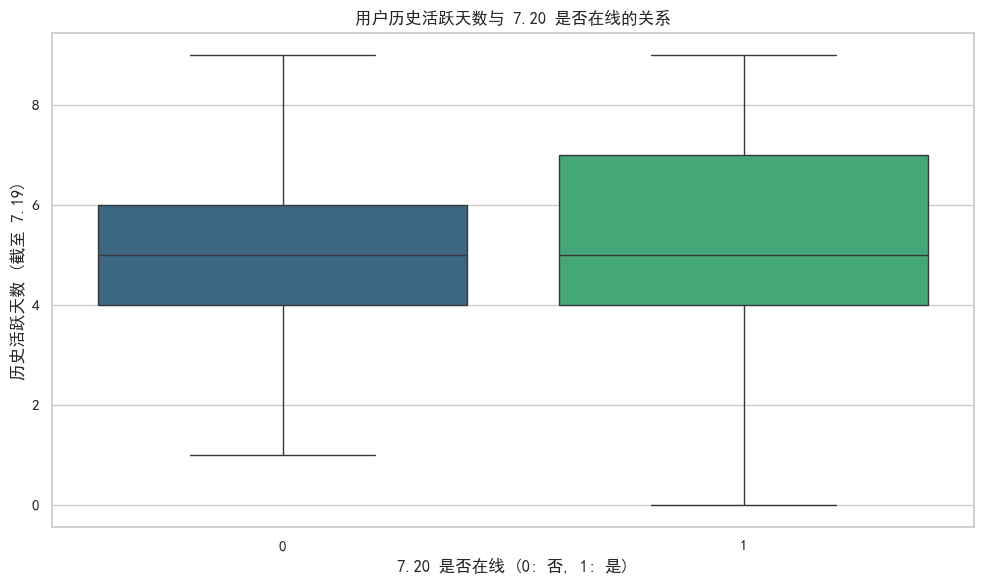

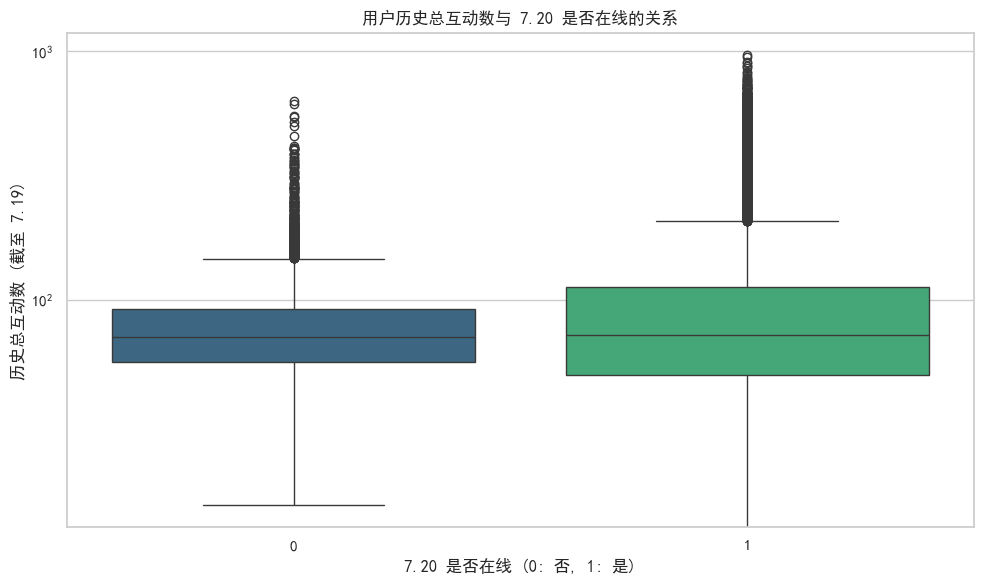

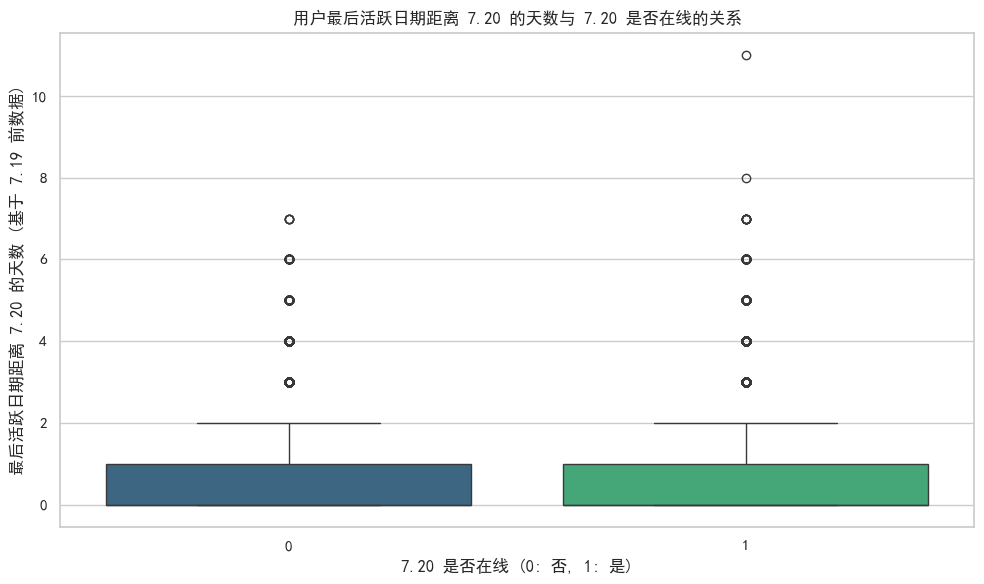


Visualizing features for interaction prediction...


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

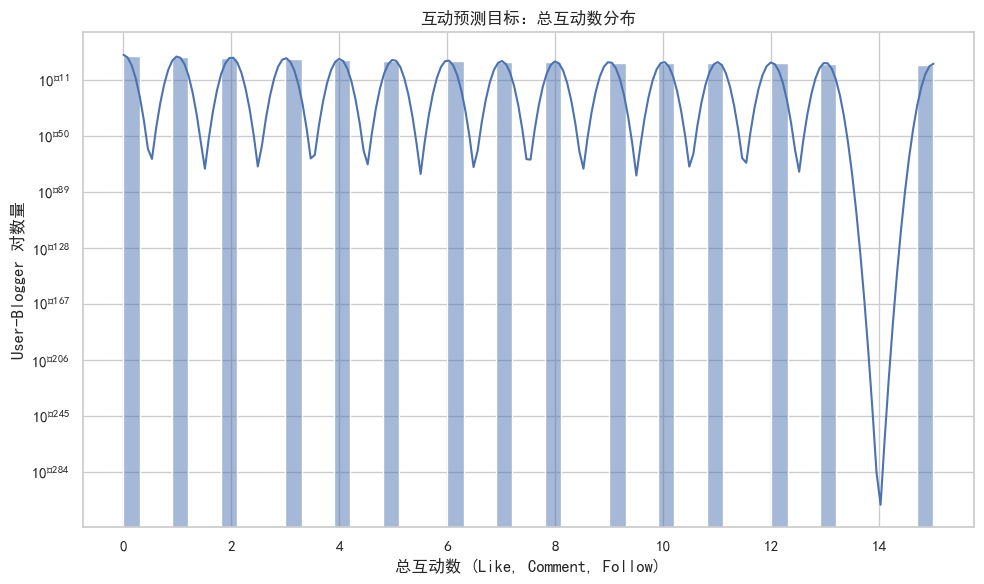

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

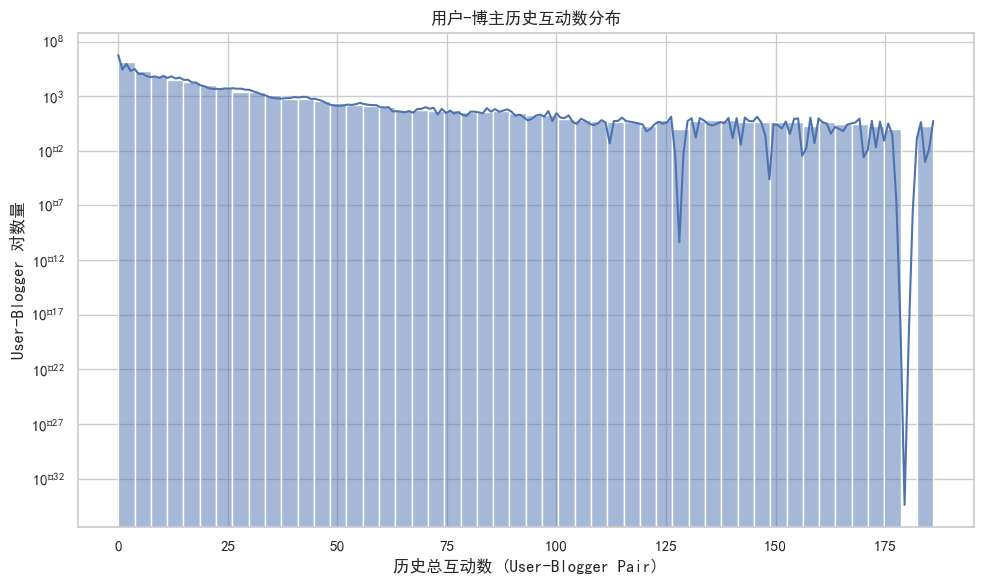

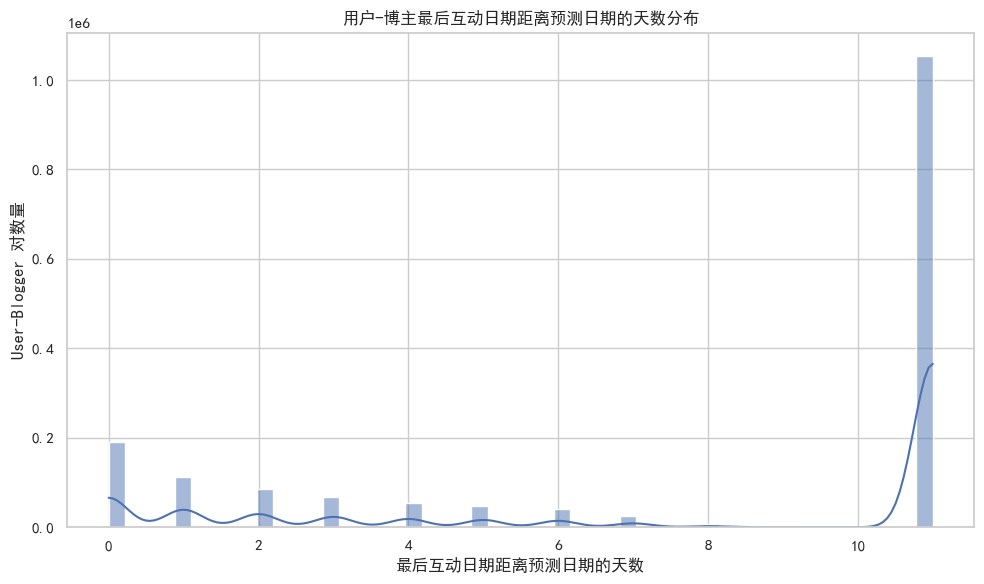


Data distribution visualization finished. Plots saved as PDF files.


In [92]:
# %% [markdown]
# ### 数据分布可视化


# 设置 matplotlib 和 seaborn 的样式，让图表更好看
sns.set_theme(style="whitegrid")
plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]  # 设置中文显示
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 假设 df_hist, user_features_train_online, interaction_train_df 已经准备好

print("Starting data distribution visualization...")

# --- 1. 历史数据整体分布 ---

# 每日活跃用户数
plt.figure(figsize=(10, 6))
df_hist.groupby("Date")["UserID"].nunique().plot(kind="bar")
plt.title("每日活跃用户数 (7.11 - 7.20)")
plt.xlabel("日期")
plt.ylabel("活跃用户数")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("daily_active_users.pdf", format="pdf")
plt.show()

# 行为类型分布
plt.figure(figsize=(8, 6))
sns.countplot(x="UserBehaviour", data=df_hist, palette="viridis")
plt.title("历史行为类型分布 (1:view, 2:like, 3:comment, 4:follow)")
plt.xlabel("行为类型")
plt.ylabel("数量")
plt.xticks(
    ticks=[0, 1, 2, 3], labels=["View (1)", "Like (2)", "Comment (3)", "Follow (4)"]
)
plt.tight_layout()
plt.savefig("behavior_type_distribution.pdf", format="pdf")
plt.show()

# 历史互动总数分布 (这里只考虑 like, comment, follow)
# 可以在 df_hist 中筛选出互动行为，然后计算总互动数
interaction_behaviors = df_hist[df_hist["UserBehaviour"].isin([2, 3, 4])].copy()
user_total_interactions = (
    interaction_behaviors.groupby("UserID")
    .size()
    .reset_index(name="total_interaction_count_hist")
)

plt.figure(figsize=(10, 6))
# 使用直方图观察分布
sns.histplot(user_total_interactions["total_interaction_count_hist"], bins=50, kde=True)
plt.title("用户历史总互动数分布 (Like, Comment, Follow)")
plt.xlabel("总互动数")
plt.ylabel("用户数量")
plt.yscale("log")  # 互动数分布通常是长尾的，使用log scale更清晰
plt.tight_layout()
plt.savefig("user_total_interactions_distribution.pdf", format="pdf")
plt.show()


# --- 2. 在线预测特征与目标变量的关系 (使用 user_features_train_online) ---

print("\nVisualizing features for online prediction...")

# 检查 'user_features_train_online' DataFrame 是否存在
if "user_features_train_online" in locals() and not user_features_train_online.empty:

    # 用户历史活跃天数与是否在线的关系
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="is_online",
        y="user_active_days",
        data=user_features_train_online,
        palette="viridis",
    )
    plt.title("用户历史活跃天数与 7.20 是否在线的关系")
    plt.xlabel("7.20 是否在线 (0: 否, 1: 是)")
    plt.ylabel("历史活跃天数 (截至 7.19)")
    plt.tight_layout()
    plt.savefig("user_active_days_vs_is_online.pdf", format="pdf")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="is_online",
        y="user_hist_interactions",
        data=user_features_train_online,
        palette="viridis",
    )
    plt.title("用户历史总互动数与 7.20 是否在线的关系")
    plt.xlabel("7.20 是否在线 (0: 否, 1: 是)")
    plt.ylabel("历史总互动数 (截至 7.19)")  # 注意这里的互动数是截至 7.19
    plt.yscale("log")  # 互动数分布通常是长尾的，使用log scale更清晰
    plt.tight_layout()
    plt.savefig("user_hist_interactions_vs_is_online_filled.pdf", format="pdf")
    plt.show()

    # 用户最后活跃日期距离预测日期的天数与是否在线的关系
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="is_online",
        y="user_days_since_last_active",
        data=user_features_train_online,
        palette="viridis",
    )
    plt.title("用户最后活跃日期距离 7.20 的天数与 7.20 是否在线的关系")
    plt.xlabel("7.20 是否在线 (0: 否, 1: 是)")
    plt.ylabel("最后活跃日期距离 7.20 的天数 (基于 7.19 前数据)")
    plt.tight_layout()
    plt.savefig("user_days_since_last_active_vs_is_online_filled.pdf", format="pdf")
    plt.show()

    # 更多特征可以类似绘制 boxplot 或 violinplot

else:
    print(
        "'user_features_train_online' DataFrame not found or is empty. Skipping online feature visualization."
    )


# --- 3. 互动预测特征分布 (使用 interaction_train_df) ---

print("\nVisualizing features for interaction prediction...")

# 检查 'interaction_train_df' DataFrame 是否存在
if "interaction_train_df" in locals() and not interaction_train_df.empty:

    # 预测目标：总互动数分布
    plt.figure(figsize=(10, 6))
    sns.histplot(interaction_train_df["total_interaction_count"], bins=50, kde=True)
    plt.title("互动预测目标：总互动数分布")
    plt.xlabel("总互动数 (Like, Comment, Follow)")
    plt.ylabel("User-Blogger 对数量")
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig("interaction_target_distribution.pdf", format="pdf")
    plt.show()

    # 用户-博主历史互动数分布 (作为预测互动数的特征)
    plt.figure(figsize=(10, 6))
    sns.histplot(interaction_train_df["ub_hist_interactions"], bins=50, kde=True)
    plt.title("用户-博主历史互动数分布")
    plt.xlabel("历史总互动数 (User-Blogger Pair)")
    plt.ylabel("User-Blogger 对数量")
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig("ub_hist_interactions_distribution_filled.pdf", format="pdf")
    plt.show()

    # 用户-博主最后互动日期距离预测日期的天数分布
    plt.figure(figsize=(10, 6))
    sns.histplot(
        interaction_train_df["ub_days_since_last_interaction"], bins=50, kde=True
    )
    plt.title("用户-博主最后互动日期距离预测日期的天数分布")
    plt.xlabel("最后互动日期距离预测日期的天数")
    plt.ylabel("User-Blogger 对数量")
    plt.tight_layout()
    plt.savefig("ub_days_since_last_interaction_distribution_filled.pdf", format="pdf")
    plt.show()

    # 更多特征可以类似绘制 histplot 或 boxplot

else:
    print(
        "'interaction_train_df' DataFrame not found or is empty. Skipping interaction feature visualization."
    )


print("\nData distribution visualization finished. Plots saved as PDF files.")